Instructions: To run, upload notebook to Google Colab and change runtime type to T4 GPU

Base CNN from: https://github.com/rasbt/machine-learning-book/blob/main/ch14/ch14_part1.ipynb

In [24]:
!pip install aws-fortuna

In [123]:
import time
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch

import sys
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import sklearn
import sklearn.model_selection
from torch.nn.functional import one_hot
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(20000))

###
mnist_calib_dataset, mnist_valid_dataset = random_split(mnist_valid_dataset, [10000, 10000])
###

mnist_train_dataset = Subset(mnist_dataset, torch.arange(20000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

In [124]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

###
calib_dl = DataLoader(mnist_calib_dataset, batch_size=10000, shuffle=True)#, pin_memory=True)
###

In [125]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [126]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [127]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))

model.add_module('fc2', nn.Linear(1024, 10))

In [128]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

model = model.to(device)

In [129]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9394 val_accuracy: 0.9820
Epoch 2 accuracy: 0.9812 val_accuracy: 0.9862
Epoch 3 accuracy: 0.9876 val_accuracy: 0.9892
Epoch 4 accuracy: 0.9901 val_accuracy: 0.9907
Epoch 5 accuracy: 0.9926 val_accuracy: 0.9895
Epoch 6 accuracy: 0.9941 val_accuracy: 0.9884
Epoch 7 accuracy: 0.9947 val_accuracy: 0.9904
Epoch 8 accuracy: 0.9944 val_accuracy: 0.9908
Epoch 9 accuracy: 0.9957 val_accuracy: 0.9917
Epoch 10 accuracy: 0.9965 val_accuracy: 0.9885
Epoch 11 accuracy: 0.9968 val_accuracy: 0.9913
Epoch 12 accuracy: 0.9967 val_accuracy: 0.9915
Epoch 13 accuracy: 0.9972 val_accuracy: 0.9893
Epoch 14 accuracy: 0.9976 val_accuracy: 0.9921
Epoch 15 accuracy: 0.9970 val_accuracy: 0.9914
Epoch 16 accuracy: 0.9980 val_accuracy: 0.9911
Epoch 17 accuracy: 0.9978 val_accuracy: 0.9906
Epoch 18 accuracy: 0.9977 val_accuracy: 0.9900
Epoch 19 accuracy: 0.9980 val_accuracy: 0.9920
Epoch 20 accuracy: 0.9988 val_accuracy: 0.9915


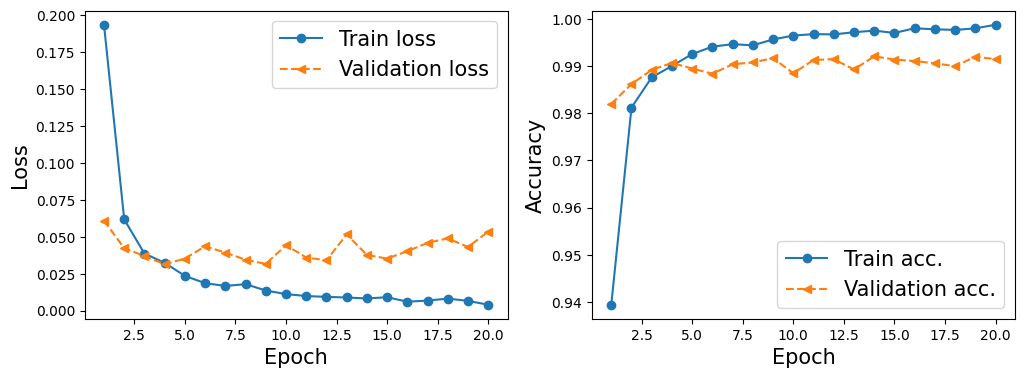

In [130]:
import matplotlib.pyplot as plt

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [143]:
torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9934


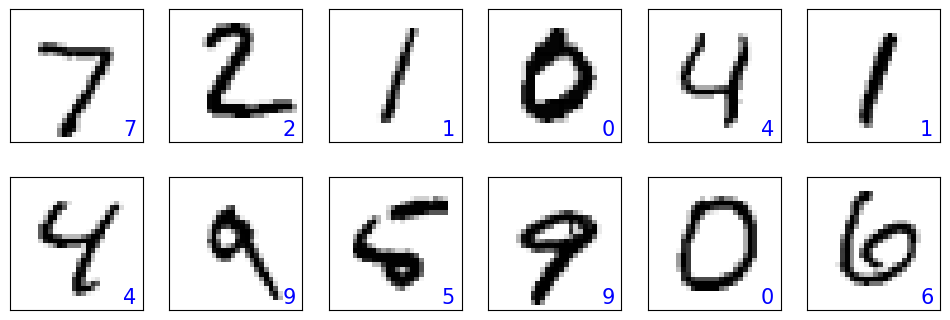

In [132]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)


#plt.savefig('figures/14_14.png')
plt.show()

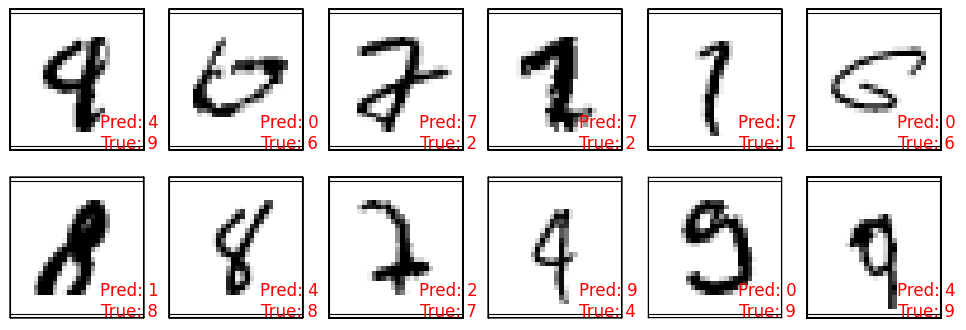

In [133]:
fig = plt.figure(figsize=(12, 4))
misclassified_count = 0

for i in range(len(mnist_test_dataset)):
    ax = fig.add_subplot(2, 6, misclassified_count + 1)
    ax.set_xticks([]); ax.set_yticks([])
    img, true_label = mnist_test_dataset[i]
    img = img[0]  # Extracting the image tensor
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)

    if y_pred != true_label:
        ax.imshow(img, cmap='gray_r')
        ax.text(0.9, 0.1, f'Pred: {y_pred.item()}\nTrue: {true_label}',
                size=12, color='red',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
        misclassified_count += 1

    if misclassified_count >= 12:
        break

plt.show()

# Conformalize model

In [171]:
model = model.to(device)

In [147]:
calib_preds = None
calib_labels = None

with torch.no_grad():
  for x_batch, y_batch in calib_dl:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      calib_pred = model(x_batch)
      calib_preds = calib_pred

      calib_labels = y_batch

      is_correct = (torch.argmax(calib_pred, dim=1) == y_batch).float().cpu().numpy()
      print(is_correct.mean())

0.9904


In [56]:
# from fortuna.output_calib_model import OutputCalibClassifier

# calib_model = OutputCalibClassifier()
# calib_status = calib_model.calibrate(
#     calib_outputs=calib_preds.cpu().numpy(), calib_targets=calib_labels.cpu().numpy()
# )

In [161]:
from fortuna.conformal import AdaptivePredictionConformalClassifier

alpha = 0.01

# val_means = prob_model.predictive.mean(inputs_loader=val_data_loader.to_inputs_loader())

conformal_sets = AdaptivePredictionConformalClassifier().conformal_set(
    val_probs=calib_preds.cpu().numpy(),
    test_probs=pred.detach().cpu().numpy(),
    val_targets=calib_labels.cpu().numpy(),
    error=alpha,
)

In [151]:
len(conformal_sets)

10000

In [153]:
import numpy as np

test_outputs = pred.detach().cpu().numpy()
test_targets = mnist_test_dataset.targets.cpu().numpy()

avg_size = np.mean([len(s) for s in np.array(conformal_sets, dtype="object")])
avg_size_wellclassified = np.mean(
    [
        len(s)
        for s in np.array(conformal_sets, dtype="object")[np.argmax(test_outputs, axis=1) == test_targets]
    ]
)
avg_size_misclassified = np.mean(
    [
        len(s)
        for s in np.array(conformal_sets, dtype="object")[np.argmax(test_outputs, axis=1) != test_targets]
    ]
)
print(f"Average conformal set size: {avg_size}")
print(
    f"Average conformal set size over well classified input: {avg_size_wellclassified}"
)
print(f"Average conformal set size over misclassified input: {avg_size_misclassified}")

Average conformal set size: 2.9573
Average conformal set size over well classified input: 2.9627541775719752
Average conformal set size over misclassified input: 2.1363636363636362


In [163]:
# ^ same in docs: https://aws-fortuna.readthedocs.io/en/latest/examples/mnist_classification.html#Conformal-prediction-sets

In [156]:
# sanity check

print(test_targets[10])

print(calib_labels.cpu().numpy()[10])

print(conformal_sets[10])

0
1
[0, 2, 9]


In [162]:
count_contain = 0

for idx, sett in enumerate(conformal_sets):
  if test_targets[idx] in sett:
    count_contain += 1

print(f'Alpha: {alpha}')
print(f'Containment of true class label: {count_contain / len(test_targets)}')

Alpha: 0.01
Containment of true class label: 0.9909


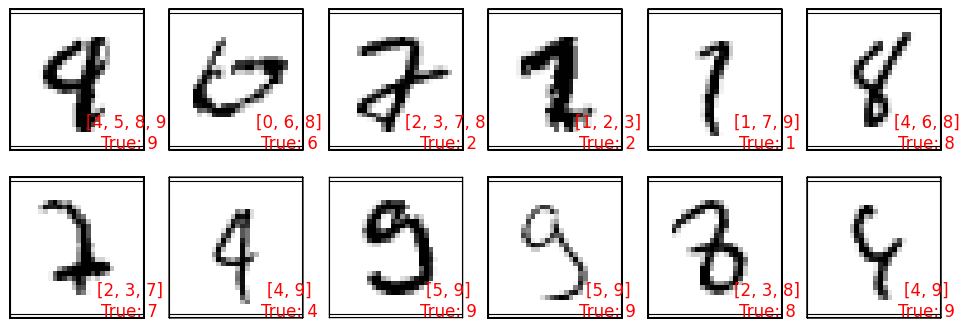

In [178]:
fig = plt.figure(figsize=(12, 4))
misclassified_count = 0

for i in range(len(mnist_test_dataset)):
    ax = fig.add_subplot(2, 6, misclassified_count + 1)
    ax.set_xticks([]); ax.set_yticks([])
    img, true_label = mnist_test_dataset[i]
    img = img[0]  # Extracting the image tensor
    pred = model((img.unsqueeze(0).unsqueeze(1)).cuda())
    y_pred = torch.argmax(pred)

    if (y_pred != true_label) and (len(conformal_sets[i])>1): ### fix this
        ax.imshow(img, cmap='gray_r')
        ax.text(0.9, 0.1, f'{conformal_sets[i]}\nTrue: {true_label}',
                size=12, color='red',
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
        misclassified_count += 1

    if misclassified_count >= 12:
        break

plt.show()

In [176]:
c=0
for sett in conformal_sets:
  if len(sett) == 0:
    c+=1
c

67

In [ ]:
# ran out of free compute units